In [1]:
%matplotlib inline

# Version 2 du modèle prédictif

Dans ce notebook, nous allons améliorer le modèle V1 en prenant en compte d'autres prédicteurs dans le modèle linéaire. 

On commence par importer les données dont on aura besoin (le tout est rassemblé en une seule cellule cette fois-ci) :

In [35]:
import pandas as pd
import numpy as np

league = pd.read_csv('data\\league.csv', index_col=0)
team = pd.read_csv('data\\team.csv', index_col=0)
match = pd.read_csv('data\\match.csv', index_col=0, parse_dates=[6], infer_datetime_format=True)

match.drop(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 
            'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'], 
           axis=1, inplace=True)

match.drop(['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 
            'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10',
            'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 
            'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 
            'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 
            'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 
            'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 
            'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 
            'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1',
            'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 
            'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2',
            'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 
            'away_player_9', 'away_player_10', 'away_player_11'],
          axis=1, inplace=True)

match.drop(['country_id', 'season', 'stage', 'match_api_id'],
           axis=1, inplace=True)

# On trie par date et on reindex
match.sort_values(by='date', inplace=True)
match.index = range(0,len(match))

match.head()

,id,league_id,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
0,24559,24558,2008-07-18,10192,9931,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24560,24558,2008-07-19,9930,10179,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24561,24558,2008-07-20,10199,9824,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24562,24558,2008-07-20,7955,10243,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24614,24558,2008-07-23,6493,7955,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On va maintenant construire les nouvelles variables à partir des informations à disposition, à savoir :
- le temps de récupération (ie. le nombre de jours entre le dernier match et le jour j)
- le nombre de matchs dans le mois
- la dynamique : c'est l'historique des 5 derniers matchs (ex: GGPPN)
- le nombre de buts ajustés : on va pour cela considérer
    - les buts qui permettent à une équipe de mener compte 1.2
    - les tirs cadrés par rapport à la position (distance + angle) (pondération à définir)
    - somme tirs cadrés + tirs non cadrés
    - ratio tirs cadrés / tirs non cadrés
    - compter 0.8 un but quand l'équipe adverse s'est prise en carton rouge
    - corner, coup franc indirect comptent pour 0.1 ?
    

## Conditions du match

Commençons par le temps de récupération :

In [180]:
def calcul_recup(row, home=True):    
    # on récupère l'équipe et la date du match
    if home:
        equipe, jourJ = (row.home_team_api_id, row.date)
    else:
        equipe, jourJ = (row.away_team_api_id, row.date)
      
    # on récupère tous les matchs précédents de l'équipe
    match_precedents = match[:row.name][(match.home_team_api_id == equipe) | (match.away_team_api_id == equipe)]
    
    # Si il n'y en a aucun, on compte le maximum de récupération, sinon on retourne le nombre de jours
    if match_precedents.id.count() == 0:
        return 15
    else:
        deltaT = np.min(jourJ - match_precedents.date)
        return min(deltaT.days, 15)
    
match['recuperation_home'] = match.apply(lambda row: calcul_recup(row), axis=1)
match['recuperation_away'] = match.apply(lambda row: calcul_recup(row, home=False), axis=1)

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


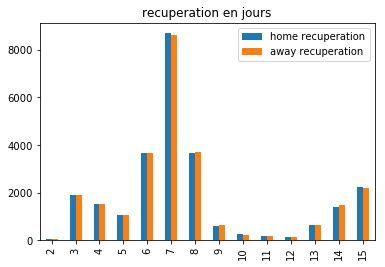

In [181]:
df_home = pd.DataFrame(match['recuperation_home'].value_counts()).sort_index()
df_away = pd.DataFrame(match['recuperation_away'].value_counts()).sort_index()

#on merge les deux
df_home_away = df_home.merge(df_away, how='outer', left_index=True, right_index=True)
df_home_away.columns = ['home recuperation', 'away recuperation']

#on affiche les deux histogrammes
df_home_away.plot(kind='bar', title='recuperation en jours')

On peut regarder si on observe une tendance quand le nombre de jours de repos augmente :

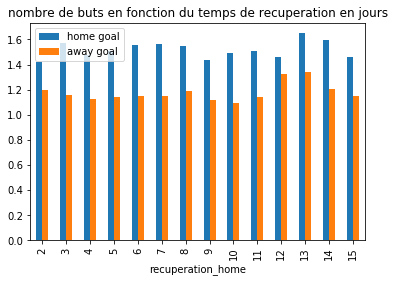

In [182]:
df_home = pd.DataFrame(match[['recuperation_home','home_team_goal']].groupby(by='recuperation_home').mean()).sort_index()
df_away = pd.DataFrame(match[['recuperation_away','away_team_goal']].groupby(by='recuperation_away').mean()).sort_index()

#on merge les deux
df_home_away = df_home.merge(df_away, how='outer', left_index=True, right_index=True)
df_home_away.columns = ['home goal', 'away goal']

#on affiche les deux histogrammes
df_home_away.plot(kind='bar', title='nombre de buts en fonction du temps de recuperation en jours')

On observe pas vraiment d'effet, sauf peut être sur la fin...

On calcule maintenant la dynamique :

In [183]:
def vainqueur(row):
    if row.home_team_goal > row.away_team_goal:
        return 'H'
    elif row.home_team_goal > row.away_team_goal:
        return 'A'
    else:
        return 'N'
    
match['vainqueur'] = match.apply(vainqueur, axis=1)

In [184]:
def dynamique(row, home=True):
    # on récupère l'équipe et la date du match
    if home:
        equipe, jourJ = (row.home_team_api_id, row.date)
    else:
        equipe, jourJ = (row.away_team_api_id, row.date)
        
    match_precedents = match[:row.name][(match.home_team_api_id == equipe) | (match.away_team_api_id == equipe)]
    
    # On trie par date et on reindex pour être sur
    match_precedents.sort_values(by='date', inplace=True)
    match_precedents.index = range(0,len(match_precedents))
    
    dyn = ''
    # On prend maximum les 5 derniers matchs
    for i in range(min(5,match_precedents.id.count())):
        row = match_precedents.iloc[[i]]
        # Si l'équipe qu'on regarde a joué à domicile
        if equipe == row.home_team_api_id.values:
            if row.vainqueur.values == 'H':
                dyn += 'G'
            elif row.vainqueur.values == 'A':
                dyn += 'P'
            else:
                dyn += 'N'
        # Sinon c'est que c'était l'équipe qui jouait à l'exterieur
        else:
            if row.vainqueur.values == 'A':
                dyn += 'G'
            elif row.vainqueur.values == 'H':
                dyn += 'P'
            else:
                dyn += 'N'
    
    # Si il n'existe pas de match avant, on rempli par des matchs nuls            
    if len(dyn) < 5:
        dyn = dyn + ('N' * (5-len(dyn)))
        
    return dyn[::-1] # on renverse la chaine de caractère, car on veut du plus vieux au plus jeune de gauche à droite
    
match['home_dynamique'] = match.apply(lambda row: dynamique(row), axis=1)
match['away_dynamique'] = match.apply(lambda row: dynamique(row, home=False), axis=1)

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [185]:
def score_dyn(dyn):
    score = 0
    for i in range(5):
        score = score + (1 if dyn[i] == 'G' else -1 if dyn[i] == 'P' else 0) * (float(i+1)/float(5))
    return score

match['home_score_dynamique'] = match.home_dynamique.apply(score_dyn)
match['away_score_dynamique'] = match.away_dynamique.apply(score_dyn)

On enregistre la nouvelle base de données (le calcul a pris des heures, on va pas le faire à chaque fois...)

In [186]:
match.to_csv('data\\match_enhanced.csv', encoding='utf-8')

On charge les données si on les avais pas avant

In [36]:
match = pd.read_csv('data\\match_enhanced_global.csv', index_col=0, parse_dates=[3], infer_datetime_format=True)

On va désormais se concentrer sur la ligue 1 anglaise car c'est celle qui possède le plus de données (on pourrait pour l'instant travailler sur les autres, mais ce sera bloquant dans le prochain notebook)

In [37]:
match_league1 = match[match.league_id == 1729]

In [38]:
match_league1.drop(['id','league_id','date','goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession'],
           axis=1, inplace=True)

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [39]:
match_league1

,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_long_name,away_team_long_name,recuperation_home,recuperation_away,vainqueur,home_dynamique,away_dynamique,home_score_dynamique,away_score_dynamique
53,8668,8655,2,3,Everton,Blackburn Rovers,15,15,N,NNNNN,NNNNN,0.0,0.0
55,9825,8659,1,0,Arsenal,West Bromwich Albion,15,15,H,NNNNN,NNNNN,0.0,0.0
69,8559,10194,3,1,Bolton Wanderers,Stoke City,15,15,H,NNNNN,NNNNN,0.0,0.0
73,8549,8586,2,1,Middlesbrough,Tottenham Hotspur,15,15,H,NNNNN,NNNNN,0.0,0.0
78,8472,8650,0,1,Sunderland,Liverpool,15,15,N,NNNNN,NNNNN,0.0,0.0
83,8654,8528,2,1,West Ham United,Wigan Athletic,15,15,H,NNNNN,NNNNN,0.0,0.0
84,8667,9879,2,1,Hull City,Fulham,15,15,H,NNNNN,NNNNN,0.0,0.0
89,8455,8462,4,0,Chelsea,Portsmouth,15,15,H,NNNNN,NNNNN,0.0,0.0
91,10260,10261,1,1,Manchester United,Newcastle United,15,15,N,NNNNN,NNNNN,0.0,0.0
99,10252,8456,4,2,Aston Villa,Manchester City,15,15,H,NNNNN,NNNNN,0.0,0.0


## Construction du modèle

Maintenant que les données sont propres et identifiées, on va construire le modèle pymc3. Déjà, on va se concentrer maintenant sur la ligue 1 anglaise car c'est celle qui possède le plus de données. Ensuite, il faut changer les noms des équipes en indices allant de 1 au nombre total d'équipe

In [40]:
teams = match_league1.home_team_long_name.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
num_teams = len(match_league1.away_team_api_id.unique())

In [41]:
teams

,team,i
0,Everton,0
1,Arsenal,1
2,Bolton Wanderers,2
3,Middlesbrough,3
4,Sunderland,4
5,West Ham United,5
6,Hull City,6
7,Chelsea,7
8,Manchester United,8
9,Aston Villa,9


In [42]:
match_league1 = pd.merge(match_league1, teams, left_on='home_team_long_name', right_on='team', how='left')
match_league1 = match_league1.rename(columns = {'i': 'i_home'}).drop('team', 1)
match_league1 = pd.merge(match_league1, teams, left_on='away_team_long_name', right_on='team', how='left')
match_league1 = match_league1.rename(columns = {'i': 'i_away'}).drop('team', 1)

On split notre jeu de données (60/20/20) afin de pouvoir mesurer plus tard les perfomances des différents modèles testés. NB : on fait exprès de ne pas randomiser les individus qui iront en train/CV/test. En effet, les observations sont ordonnées dans le temps, et en application réelle, on a accès uniquement au passé pour prédire le futur.

In [44]:
# On compte le nombre d'observations dont on dispose
taille_totale = match_league1.home_team_goal.count()
# on calcule le nombre d'observations que l'on envoie en training set
train_size = int(taille_totale*0.6)
CV_size = int(taille_totale*0.8)

observed_home_goals = match_league1.home_team_goal.values[:train_size]
observed_away_goals = match_league1.away_team_goal.values[:train_size]

home_team = match_league1.i_home.values[:train_size]
away_team = match_league1.i_away.values[:train_size]

home_recuperation = np.array(match_league1.recuperation_home.values[:train_size], dtype=np.float64)
away_recuperation = np.array(match_league1.recuperation_away.values[:train_size], dtype=np.float64)

home_dynamique = np.array(match_league1.home_score_dynamique.values[:train_size], dtype=np.float64)
away_dynamique = np.array(match_league1.away_score_dynamique.values[:train_size], dtype=np.float64)

On décrit notre modélisation. On commence par spécifier les entrées et sorties de notre modélisation ![title](illustrations/V1.png)

In [45]:
import theano

model_input_team = theano.shared(np.array([home_team, away_team]))
model_input_conditions = theano.shared(np.array([home_recuperation, away_recuperation, home_dynamique, away_dynamique]))
model_output = theano.shared(np.array([observed_home_goals, observed_away_goals]))

Puis on écrit le modèle

In [48]:
import pymc3 as pm

model = pm.Model()
with pm.Model() as model:
    # Paramètres spécifiques à chaque équipe  
    attaque = pm.StudentT("attaque", nu=3, mu=0, lam=1, shape=num_teams)
    defense = pm.StudentT("defense", nu=3, mu=0, lam=1, shape=num_teams)
    
    # Paramètre lié aux conditions du match
    coeff_home = pm.StudentT("coeff_home", nu=3, mu=0, lam=1, shape=1)
    coeff_recup = pm.StudentT("coeff_recup", nu=3, mu=0, lam=1, shape=1)
    coeff_dynamique = pm.StudentT("coeff_dynamique", nu=3, mu=0, lam=1, shape=1)
    coeff_perf = pm.StudentT("coeff_perf", nu=3, mu=0, lam=1, shape=1)
    
    # et un intercept
    intercept = pm.StudentT("intercept", nu=3, mu=0, lam=1, shape=1)
    
    # et du bruit
    eps = pm.Normal('eps', mu=0, sd=1, shape=2)
    
    home_theta  = pm.math.exp(intercept + 
                              coeff_home + 
                              coeff_recup * (model_input_conditions[0] - model_input_conditions[1]) + 
                              coeff_dynamique * (model_input_conditions[2] - model_input_conditions[3]) +
                              coeff_perf * (attaque[model_input_team[0]] - defense[model_input_team[1]]) +
                              eps[0]
                              )
    away_theta  = pm.math.exp(intercept + 
                              coeff_recup * (model_input_conditions[1] - model_input_conditions[0]) +
                              coeff_dynamique * (model_input_conditions[3] - model_input_conditions[2]) +
                              coeff_perf * (attaque[model_input_team[1]] - defense[model_input_team[0]]) +
                              eps[1]
                             )

    # likelihood of observed data 
    home_points = pm.Poisson('home_points', mu=home_theta, observed=model_output[0])
    away_points = pm.Poisson('away_points', mu=away_theta, observed=model_output[1])

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -6,016.8: 100%|██████████████████████████████████████████████████| 20000/20000 [00:35<00:00, 557.97it/s]
Finished [100%]: Average ELBO = -5,733.1
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [08:13<00:00,  3.70it/s]


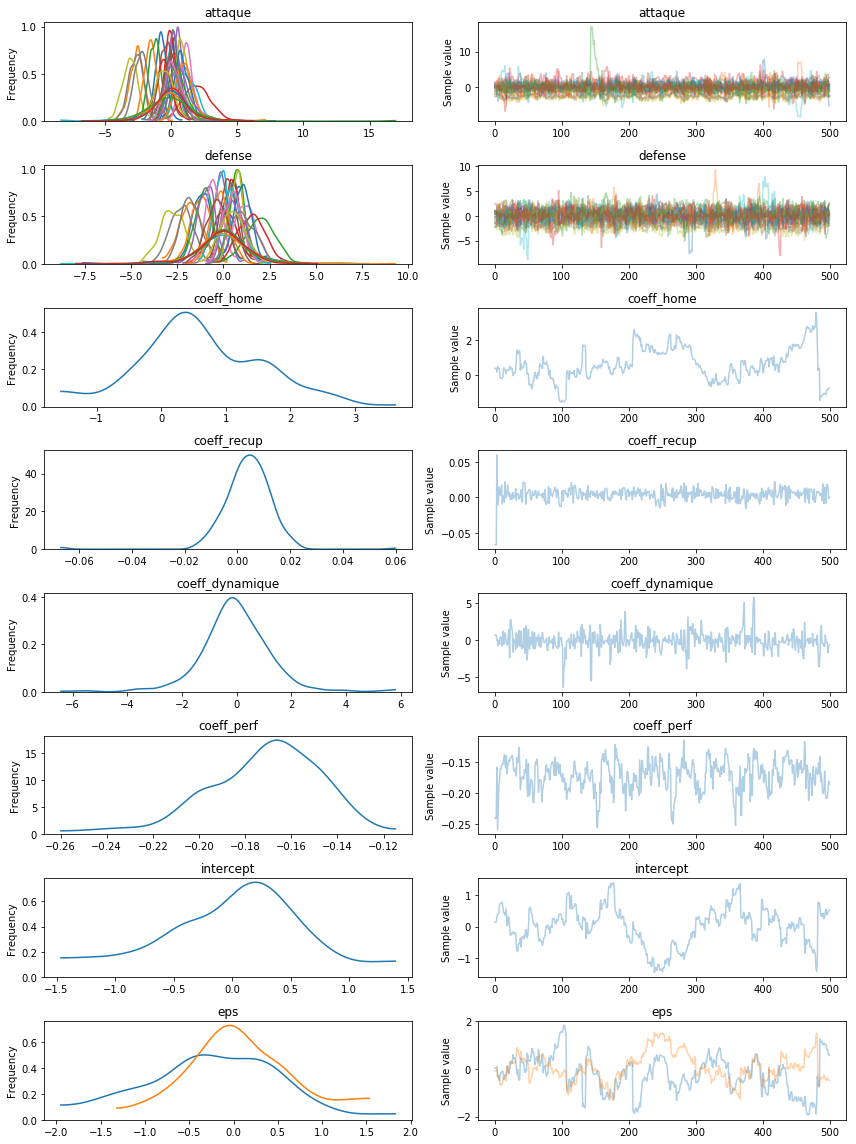

In [49]:
with model:
    trace = pm.sample(500, n_init=20000)

    pm.traceplot(trace)

La phase de sampling étant terminé, on va afficher pour chaque équipe la ditribution à posteriori des paramètres d'attaque et de défense sous forme de forestplot : 

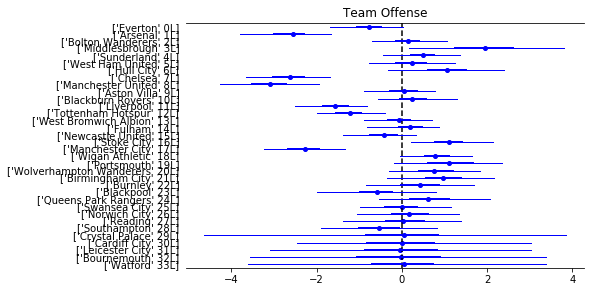

In [50]:
pm.forestplot(trace[10:], varnames=['attaque'], ylabels=teams.values, main="Team Offense", chain_spacing=0.2)

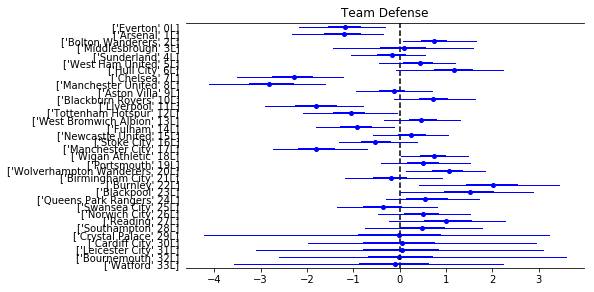

In [51]:
pm.forestplot(trace[10:], varnames=['defense'], ylabels=teams.values, main="Team Defense", chain_spacing=0.2)

Les résultats semblent cohérents (le trio de tête est Chelsea - Manchester United - Arsenal)

# Evaluation des perfomances du modèle

On mesure maintenant les performances du modèle. La méthode est la même quand le notebook précédent, on va donc condenser les cellules et enlever les textes de commentaire.

In [52]:
"""On définit les nouvelles entrées et sorties"""
observed_home_goals = match_league1.home_team_goal.values[train_size+1:CV_size]
observed_away_goals = match_league1.away_team_goal.values[train_size+1:CV_size]

home_team = match_league1.i_home.values[train_size+1:CV_size]
away_team = match_league1.i_away.values[train_size+1:CV_size]

home_recuperation = np.array(match_league1.recuperation_home.values[train_size+1:CV_size], dtype=np.float64)
away_recuperation = np.array(match_league1.recuperation_away.values[train_size+1:CV_size], dtype=np.float64)

home_dynamique = np.array(match_league1.home_score_dynamique.values[train_size+1:CV_size], dtype=np.float64)
away_dynamique = np.array(match_league1.away_score_dynamique.values[train_size+1:CV_size], dtype=np.float64)

"""On les rentres dans les shared value theano"""
model_input_team.set_value(np.array([home_team,away_team], dtype=np.int32))
model_input_conditions.set_value(np.array([home_recuperation,away_recuperation,home_dynamique,away_dynamique], dtype=np.float64))

"""Et on sample"""
ppc = pm.sample_ppc(trace[10:], model=model, samples=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  2.65it/s]


L'échantillon est désormais créé, on va maintenant comparer nos prédictions avec la réalité :

In [53]:
"""On rassemble dans des dataframe"""
away_prediction = pd.DataFrame(ppc['away_points'])
home_prediction = pd.DataFrame(ppc['home_points'])  

prediction_score = [home_prediction[[i]].merge(away_prediction[[i]], 
                                               how='inner', 
                                               left_index=True, right_index=True) 
                    for i in range(len(home_team))]

for df in prediction_score:
    df.columns = ['home_prediction', 'away_prediction']
    
"""Pour chaque dataframe, on détermine l'équipe qui gagne"""
def vainqueur(row):
    if row[0] > row[1]:
        return 'H'
    elif row[0] < row[1]:
        return 'A'
    else:
        return 'N'
    
for df in prediction_score:
    df['prediction_vainqueur'] = df.apply(vainqueur, axis=1) 
    
"""Et on ajoute le score le plus probable"""
resultats = list()
    
for df in prediction_score:
    home_score, away_score = df.groupby(["home_prediction", "away_prediction"]).size().idxmax()
    resultats.append(
        [df.prediction_vainqueur.value_counts().idxmax(), home_score, away_score]
    )
    
resultats = pd.DataFrame(np.array(resultats))
resultats.columns = ['prediction_vainqueur', 'prediction_home_score', 'prediction_away_score']

#on remet les scores au type int, sinon il sont converti en 'objet' ...
resultats[['prediction_home_score', 'prediction_away_score']] = resultats[['prediction_home_score', 'prediction_away_score']].astype(np.int32)

"""Enfin on met en forme les vrais résultats pour pouvoir comparer"""
vrai_home = pd.DataFrame(observed_home_goals)
vrai_away = pd.DataFrame(observed_away_goals) 

vrai_resultats = vrai_home.merge(vrai_away, how='inner', left_index=True, right_index=True)
vrai_resultats.columns = ['home_points', 'away_points']

vrai_resultats['vainqueur'] = vrai_resultats.apply(vainqueur, axis=1)

vrai_resultats = vrai_resultats.merge(resultats, how='inner', left_index=True, right_index=True)

In [54]:
vrai_resultats

,home_points,away_points,vainqueur,prediction_vainqueur,prediction_home_score,prediction_away_score
0,3,2,H,H,2,0
1,1,3,A,N,1,1
2,2,2,N,H,1,1
3,0,2,A,H,1,1
4,1,2,A,A,1,1
5,2,1,H,H,3,0
6,1,1,N,H,1,0
7,1,0,H,H,1,0
8,0,0,N,H,2,0
9,2,2,N,H,1,1


On calcule notre score :

In [55]:
from sklearn import metrics

metrics.accuracy_score(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values)

0.5403624382207578

Commentaires :
- Les résultats sont encourageant pour un modèle aussi simple (quasiment 50% de réussite, à comparer aux 33% d'une méthode complètement aléatoire)
- On prédit trop souvent Away : peut être que le modèle favorise trop l'équipe à domicile...

In [76]:
vrai_resultats.vainqueur.count()

607

In [57]:
vrai_resultats.vainqueur.value_counts() / vrai_resultats.vainqueur.count()

H    0.444811
A    0.314662
N    0.240527
Name: vainqueur, dtype: float64

prochaine étapes :
- améliorer le modèle hierarchique (prendre en compte les tirs cadrés, etc.)
- modéliser au niveau de chaque joueur ?
- écrire le code d'une simulation d'une saison entière pour obtenir le classement final

Enfin, on va compter le nombre de fois où notre projection de score est correcte

In [58]:
score_juste = vrai_resultats[vrai_resultats.home_points == vrai_resultats.prediction_home_score]
score_juste = score_juste[vrai_resultats.away_points == vrai_resultats.prediction_away_score]
len(score_juste) / float(len(vrai_resultats))

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


0.10543657331136738

On a prédit le bon score dans 14.5% des cas.

Par la suite, on améliorera le modèle selon 3 axes :
- les buts étant des évênements rares, ils sont soumis à une grande variabilité et peuvent donc être une métrique trompeuse. Il va donc falloir "l'augmenter" avec d'autres évênements moins rares, mais quasiment tout autant important : le nombre de tirs cadrés, non cadrés, corner, de pénaltis, etc.
- mieux charactériser les paramètres latents d'une équipe. On a ici résumé l'information disponible à un score d'attaque et un score de défense, mais il y en a certainement d'autres : la possession moyenne de balle par exemple ? ...
- mieux charactériser la situation du match, indépendement des performances d'une équipe : le fait de jouer à domicile a été pris en compte ici, mais on peut penser à d'autres choses, tels que le temps de repos depuis le dernier match, etc.
- prendre en compte l'évolution du style de jeu au cours des années (cf le notebook sur les buts vs loi de poisson)

Eventuellement plus tard modéliser au niveau du joueur

# Quelques analyses en plus 

In [190]:
def extract_time_elapsed(row):
    if(not pd.isnull(row)):
        tree = html.fromstring(row)
        coord = tree.xpath('//elapsed/text()')
        return np.array(coord, dtype=np.int32)
    return np.nan

match['time_elapsed'] = match.goal.apply(lambda row: extract_time_elapsed(row))

Regardons la distribution des buts par minute d'un match

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000068D1E8D0>]], dtype=object)

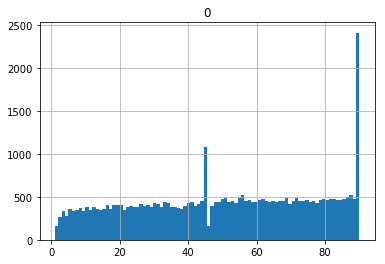

In [191]:
pd.DataFrame(np.hstack(match.time_elapsed.values)).hist(bins=90)

On observe beaucoup plus de buts à la 45ème et à la 90ème minutes ! En effet, les buts marqués pendants le temps additionel (91, 92, 93ème minutes) sont compté comme 90. Idem pour 45.

Etudions la position (distance + angle en degré) des tirs :

In [192]:
def extract_position_distance(row):
    if(not pd.isnull(row)):
        tree = html.fromstring(row)
        coord = tree.xpath('//coordinates/value/text()')
        return np.array(coord[0:][::2], dtype=np.int32)
    return np.nan

def extract_position_angle(row):
    if(not pd.isnull(row)):
        tree = html.fromstring(row)
        coord = tree.xpath('//coordinates/value/text()')
        return np.array(coord[1:][::2], dtype=np.int32)
    return np.nan

match['position_distance'] = match.goal.apply(lambda row: extract_position_distance(row))
match['position_angle'] = match.goal.apply(lambda row: extract_position_angle(row))

In [193]:
heatmap = pd.DataFrame([np.hstack(match.position_distance.values),np.hstack(match.position_angle.values)]).T
heatmap.dropna(inplace=True)
heatmap.columns = ['Distance', 'Angle']

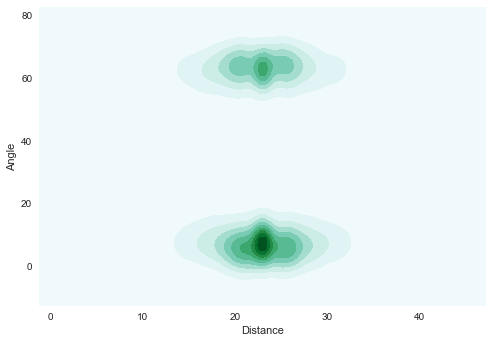

In [194]:
import seaborn
seaborn.kdeplot(heatmap.Distance, heatmap.Angle, shade=True)

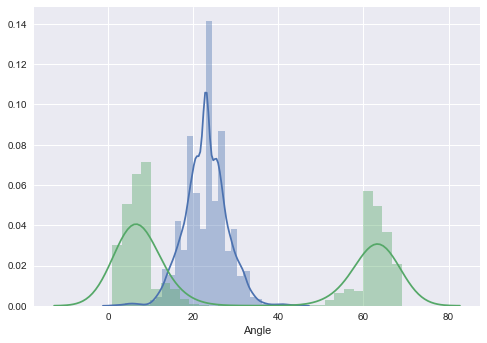

In [195]:
seaborn.distplot(heatmap.Distance, bins=30)
seaborn.distplot(heatmap.Angle, bins=30)